In [37]:
import numpy as np
from numpy import random
import math
import matplotlib.pyplot as plt
from tqdm import tqdm


# Nuclear bombs

On of the earliest recorded uses of a Monte Carlo approach was during the Manhattan Project. To get an explosion, a neutron in fissionable material needs to create on averge more than 1 neutron. It is random if a neutron will collide some atom as well if the collision will result in fission (releasing more neutrons), absorbtion or scattering.

It is cruial to know when the material will be supercritial (more than 1 neutron on average). Before the detonation you need it subcritial and then need to bring it into superciritial state.

We will use a simplified model. For a more authentic treatment see https://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-00551-MS.

We model the material as a sphere with radius $R$. Neutrons get emittet by natural decay uniformly in the sphere and will have a uniform random direction. We assume the velocity to be the same for all neutrons.

The probability that the neutron travels a length $d$ without colliding with an atom is given by $\exp(-d\lambda)$ where lambda is a propertiy of the material.

The neutron can either leave the sphere without a collision or collide with some atom inside the sphere. If the neutron does collide inside the sphere there are 3 possibilties:
- The neutron gets absorbed
- It gets scatterd (deflected in a different direction)
- It splits the atom and either two or four neutrons get released, each in a random direction

You can model scattering as a special case of fission, where only one neutron is released and absorbtion as a case of fission with no releases. We will have a probability vector $(f_0, f_1, f_2, f_4)$ desribing all four of the possibilities. We will fix all four of them to have 25%.

Your task is determine at which radius the sphere would get supercritical. For this start with 1000 naturally emitted neutrons and simulate the system for up to 100 collisions (for each neutron) and decide if it is supercritical.

In [12]:
# Calculates the length of a ray starting in `start` and going in a unit direction `dir` until it intersects a sphere with radius `r` centered in the origin.

# R: radius
# start: start of the ray
# dir: direction of the ray
# origin: [0, 0, 0]

def length_inside_sphere(R : float, start: np.array, dir: np.array) -> float:
    rcos = np.dot(start, dir)
    r = np.linalg.norm(start)
    rsin_squared = r**2 - rcos**2
    return math.sqrt(R**2 - rsin_squared) - rcos

Implement the following functions:

In [13]:
# Returns a unit vector in a random direction
def random_direction():
    # Sample random values for each dimension
    x, y, z = np.random.uniform(-1, 1, 3)

    # Create a vector from the sampled values
    vector = np.array([x, y, z])

    # Calculate the length of the vector
    length = np.linalg.norm(vector)

    # Ensure the vector is not a zero vector
    while length == 0:
        x, y, z = np.random.uniform(-1, 1, 3)
        vector = np.array([x, y, z])
        length = np.linalg.norm(vector)

    # Normalize the vector to obtain a unit vector
    unit_vector = vector / length

    return unit_vector

In [14]:
# code snippet just to check that the random direction has norm = 1
test_dir = random_direction()
print(test_dir)
print((np.linalg.norm(test_dir)))

[-0.9903068   0.05192099 -0.12882797]
0.9999999999999999


In [15]:
# Samples the length until the first colission

# lam: lambda (rate of collision)

def length_until_collision(lam: float) -> float:
    # Note the probability transformation: F_d(D)~ U[0,1]
    u = np.random.uniform()

    # Calculate the length until the first collision using the inverse transform method
    length = -math.log(1 - u) / lam #implement minus otherwise length is negative
    return(length)

    # The probability that the neutron travels a length d without colliding with an atom is given by p(d) = exp(-d*lambda)
    # This means the probability that the neutron collides during the travel is given by F(d) = 1-exp(-d*lambda)
    # This is just the cdf of the exponential function
    # We want the 'd', hence solved it: d = log(1 - F(d))/lambda

In [16]:
# code snippet just to check that the random direction has norm = 1
test_len = length_until_collision(0.1)
print(test_len)
print((np.linalg.norm(test_dir)))

1.8892631123833294
0.9999999999999999


In [17]:
#Takes the Radius and lambda, a list of start position and a list of directions for neutrons. The function simulates the trajetory of each neutron and gives a list of new position and directions.
#The sizes may change because of absortion and fission
def simulate_neutrons(R: float, lam: float, start: list[np.array], dir: list[np.array]) -> (list[np.array], list[np.array]):
    new_positions = []
    new_directions = []

    for i in range(len(start)):
        # For every neutron (starting position and direction)...
        position = start[i]
        direction = dir[i]
        
        length_to_collision = length_until_collision(lam)

        # If the collision happenend outside the sphere the neutron is gone
        if length_to_collision > length_inside_sphere(R, position, direction):
            #print("iteration: ", i, " plop!plop!")
            continue # jumps back up to for loop starting the next iteration

        # ...if it reacted inside the sphere, calculate the position of collision
        position += length_to_collision * direction

        # Simulate fission or absorption
        fission_probabilities = [0.25, 0.25, 0.25, 0.25]
        num_neutrons = np.random.choice([0, 1, 2, 4], p=fission_probabilities)

        for _ in range(num_neutrons):
            new_directions.append(random_direction())
            new_positions.append(position.copy())
    return new_positions, new_directions

In [18]:
### Just a test cell please ignore!!!### (but dont delete)

R = 13.5  # Example radius
lam = 0.1  # Example lambda

# Example starting position and direction
start_position = np.array([0.0, 0.0, 0.0])
start_direction = random_direction()

# Wrap the individual NumPy arrays in lists
start_position_list = [start_position]
start_direction_list = [start_direction]

# Run the simulation for one neutron
new_positions, new_directions = simulate_neutrons(R, lam, start_position_list, start_direction_list)

# Print the results for inspection
print("New Positions:", new_positions)
print("New Directions:", new_directions)

# Build on obtained positions and directions
new_positions, new_directions = simulate_neutrons(R, lam, new_positions, new_directions)

New Positions: [array([2.17343375, 1.42040053, 6.39038737])]
New Directions: [array([-0.7785995 ,  0.02525143,  0.62701291])]


In [19]:
def check_single_element(vector, name):
    length = len(vector)
    if length != 1:
        raise ValueError(f"The {name} vector must have only 1 element!")

#Simulate a single neutron over N collision epochs. It will return the number of neutrons after N epochs. You can stop the simulation if you have more than 1000 neutrons and return 1000
def simulate_neutron_over_N_collisions(R: float, lam: float, start: np.array, dir: np.array, N: int) -> int:
    # Check if start and dir vectors have length 1
    # check_single_element(start, "start")
    # check_single_element(dir, "dir")

    for epoch in range(N):
        # Use temporary variables to store the updated positions and directions
        temp_start, temp_dir = simulate_neutrons(R, lam, start, dir)

        # Check if the system is supercritical (more than 1000 neutrons)
        if len(temp_start) >= 1000:
            return 1000

        if len(temp_start) == 0:
            return 0

        # Update the original start and dir vectors
        start, dir = temp_start, temp_dir

    
    return len(start)

In [20]:
R = 13.5

start_position = np.array([0.0, 0.0, 0.0])  # Example starting position
start_direction = random_direction()  # Example starting direction

# Wrap the individual NumPy arrays in lists
start_position_list = [start_position]
start_direction_list = [start_direction]

result = simulate_neutron_over_N_collisions(R, lam, start_position_list, start_direction_list, N=100)
print("Number of neutrons after N epochs:", result)

Number of neutrons after N epochs: 0


In [50]:
## Sample a random point in a sphere where every position is equally likely
def uniform_point_in_sphere(R):
    # Generate random polar and azimuthal angles
    theta = np.random.uniform(0, np.pi)  # Polar angle (0 to pi)
    phi = np.random.uniform(0, 2 * np.pi)  # Azimuthal angle (0 to 2*pi)

    # Convert spherical coordinates to Cartesian coordinates
    x = R * np.sin(theta) * np.cos(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(theta)

    return np.array([x, y, z])

def is_supercritical(R: float, lam: float) -> bool:
    # Start with 1000 naturally emitted neutrons
    new_neutrons = 0
    for i in range(1000):
       # Change start_positions from a single point to 3 uniform distributed values between 0 and R
        start_positions =  [uniform_point_in_sphere(R)]
        start_directions = [random_direction()]
        new_neutrons += simulate_neutron_over_N_collisions(R, lam, start_positions, start_directions, N=100)

        if(new_neutrons > 1000):
            return True

        # Check if the system is supercritical (more than 1000 neutrons)
    return False
result = is_supercritical(R=13, lam=0.1)
print("Is the system supercritical?", result)

Is the system supercritical? True


In [42]:
random.uniform(0,12.5,3)

array([9.31350344, 5.58223289, 7.7577593 ])

For $\lambda = 0.1$ determine the radius of a supercirital sphere

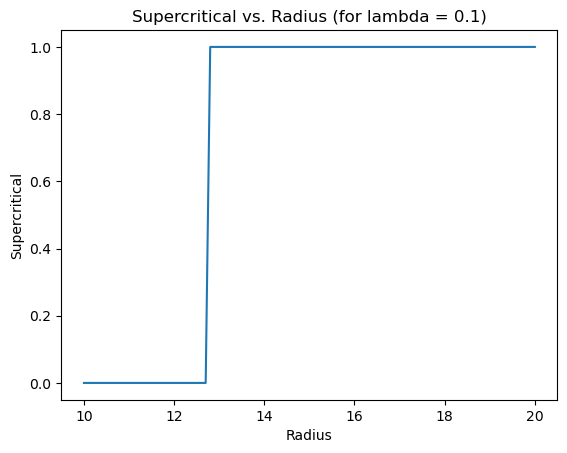

In [47]:
# Generate array of 101 values from 10 to 20 (inclusive)
R_vals = np.linspace(start=10., stop=16., num=22)

# Initialize an empty list to store supercritical flags
supercritical = []

# Iterate through radius values and check if the state is supercritical
for radius in tqdm(R_vals, desc="Processing radius values"):
    if is_supercritical(R=radius, lam=0.1):
        supercritical.append(1)
    else:
        supercritical.append(0)

# Create a line plot
plt.scatter(R_vals, supercritical)
plt.xlabel('Radius')
plt.ylabel('Supercritical')
plt.title('Supercritical vs. Radius (for lambda = 0.1)')
plt.legend()
plt.show()

In [13]:
# Your answers here...

# The critical radius has value between 12.5 and 13.
# Every radius larger than that also results in a supercritical sphere, because particles have a longer way to get outside the radius.
# This results in more opportunitites for the neutron to split atoms and releasing more neutrons.

In [14]:
def find_critical_radius(lam: float, tolerance: float = 0.0000001):
    # Initial bounds for the search
    lower_bound = 1.0
    upper_bound = 100.0

    while upper_bound - lower_bound > tolerance:
        # Midpoint of the current bounds
        mid_radius = (lower_bound + upper_bound) / 2.0

        # Check if the system is n times supercritical at the midpoint
        is_critical = is_supercritical(mid_radius, lam)

        if is_critical:
            # If supercritical, adjust the upper bound
            upper_bound = mid_radius
        else:
            # If not supercritical, adjust the lower bound
            lower_bound = mid_radius

    # The critical radius is in the middle of the final bounds
    critical_radius = (lower_bound + upper_bound) / 2.0
    return critical_radius

# Example usage with lambda = 0.1
critical_radius = find_critical_radius(lam=0.1)
print(f"The critical radius for lambda = 0.1 is approximately {critical_radius:.2f}")

The critical radius for lambda = 0.1 is approximately 12.21


# Ring Ising Model

We have $N$ random variables $S_0$, ..., $S_{N-1}$ which take values in $\{-1,1\}$. The interactions form a ring, which means the energy of the system is desribed by $E = -J \sum_{i = 0}^{N-1}  S_{i}S_{(i+1)  \mathrm{mod} N} $ where $J > 0$.

This means the probabilty of a state is proportional to $\exp(-\frac{E}{\tau})$, where $\tau > 0$ is the fundamental temperature. The fundamanetal temperature $\tau$ is defined as $\tau = k_B T$, where $k_B$ is Boltzman constant and $T$ the temperature.

Your task is to implement the Metropolis Hastings Algorithm to estimate the energy per particle $E/N$, given the fundamental temperature $\tau$ and the interaction strength $J$.

The proposal function will have a hyperparamter $\mu \in [0,1]$ which indicates the "mutation" probability. When we are at state $s_0, ..., s_{N-1}$, we change the sign of $s_i$ with a probability $\mu$ independently for all $i$.

In [2]:
# If you like you can use numpy arrays instead of lists
def energy(J : float, state: list[int]) -> float:
    # Get the product of the states
    state_product = []

    n = len(state)
    # Multiply each element with the next one and last with first
    for i in range(n - 1):
        state_product.append(state[i] * state[i + 1])
    state_product.append(state[-1] * state[0])
    E = -J * sum(state_product)
    return(E)

# Test:
energy(1, [1,2,3,4,5])

-45

In [3]:
# Implement the proposal function described above
def proposal(mu : float, state : list[int]) -> list[int]:
    # Create a copy of the state to modify
    proposed_state = state.copy()

    # Iterate through each element and change the sign with probability mu
    for i in range(len(proposed_state)):
        if random.uniform(0, 1) < mu:
            proposed_state[i] *= -1  # Change the sign

    return proposed_state
    
# Test:
proposal(0.1, [1,2,3,4,5,6,7,8,9,10])

[1, 2, 3, 4, -5, 6, 7, 8, 9, 10]

In [4]:
#Perform a step in the Metropolis Hastings algorithm to sample a new state of the system and return the new state and if the mutated state was accepted
def do_step(J: float, tau: float, mu: float, state: list[int]) -> list[int]:
    # Notice that q(z_t|z') = q(z'|z_t) as getting from one to the other needs to have the same signs flipped
    # Hence, acceptance probability is min{1, p(proposal)/p(current)}
    current_state = state
    proposed_state = proposal(mu, state)
    
    current_E = energy(J, state)
    proposed_E = energy(J, proposed_state)

    # Calculate the acceptance probability. Mind the minus in the formula in the exponent!!!
    accept_prob = min(1, np.exp((current_E - proposed_E) / tau))

    # Accept or reject the proposal based on the acceptance probability
    if random.uniform(0, 1) < accept_prob:
        return proposed_state, True # Accept
    else:
        return current_state, False # Reject
    

In [5]:
# Do the metropolis hastings step `steps` times, average the energy of all the steps (excluding the start configuration) and calculate the mutation rate
def metro_hast(J : float, tau: float, mu: float, steps: int, start: list[int]) -> float:

    total_energy = 0
    mutation_count = 0
    current_state = start

    for _ in range(steps):
        new_state, accepted = do_step(J, tau, mu, current_state)
        total_energy += energy(J, new_state)
        if accepted:
            mutation_count += 1

        current_state = new_state

    # Calculate average energy and mutation rate
    average_energy = total_energy / steps
    mutation_rate = mutation_count / steps

    return average_energy, mutation_rate

Processing mu values: 100%|██████████| 99/99 [00:07<00:00, 12.97it/s]


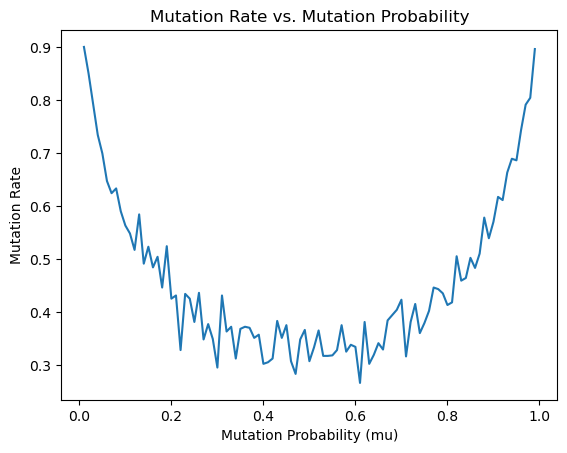

In [8]:
#Plot the mutation rate for different values of mu and describe what happens. What do you observe and why does it happen?
J = 1.0
tau = 5.0
N = 50
mu_values = []
mutation_rates = []

def plot(J: float, tau: float):
    
    for mu_int in tqdm(range(1, 100), desc="Processing mu values"):
        mu = mu_int / 100.0
        mu_values.append(mu)

        # Perform Metropolis Hastings with the current mu
        steps = 1000
        initial_state = 2* np.random.randint(2, size = N)-1
        _, mutation_rate = metro_hast(J, tau, mu, steps, initial_state)

        mutation_rates.append(mutation_rate)

    # Plot the results
    plt.plot(mu_values, mutation_rates)
    plt.xlabel('Mutation Probability (mu)')
    plt.ylabel('Mutation Rate')
    plt.title('Mutation Rate vs. Mutation Probability')
    plt.show()
plot(J, tau)

In [21]:
## As can be seen, the Mutation Rate gets smaller the closer mu is to 0.5 and it gets bigger the further mu is away from 0.5

In [9]:
#This should calculate metro_hast() / N
#Use it to compare your results (It might be needed to find a good mu)
def analytical(J: float, tau: float):
    e = (math.exp(-J/tau) - math.exp(J/tau)) / (math.exp(-J/tau) + math.exp(J/tau))
    return e

In [23]:
analytical(1,5)

-0.19737532022490403